In [70]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import json
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import torch
import nilearn
import nibabel
import nilearn.plotting as plotting
import nilearn.masking as masking
from argparse import Namespace
from data import constants
from data import dataset
import time
from conv.modules import shacgan
base_dir_ = "conv/outputs/"
run_id_ = "rfmri_unsupervised"
model_type_ = "shacgan"
def get_checkpoint(bidx, run_id=run_id_, model_type=model_type_, base_dir=base_dir_):
    return torch.load(os.path.join(base_dir, model_type, run_id, "models", "model_batch{}.checkpoint".format(bidx)))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import urllib.request as request
request.urlretrieve("http://cogspaces.github.io/assets/data/hcp_mask.nii.gz", "/data/hcp/hcp_mask.nii.gz")


('/data/hcp/hcp_mask.nii.gz', <http.client.HTTPMessage at 0x7f6577a176a0>)

In [90]:
sdf = pd.read_pickle(constants.original_statistics_pkl)
for i in range(5):
    print("{}: {}".format(sdf.iloc[i].study, sdf.iloc[i].mean_image.shape))

hcp: (91, 109, 91)
camcan: (53, 63, 52)
archi: (91, 109, 91)
brainomics: (53, 63, 46)
la5c: (91, 109, 91)


In [89]:
rdf.loc[rdf.study == 'camcan'].iloc[0].z_map

'/data/neurovault/collection_4342/image_87278.nii.gz'

# rfMRI GAN

In [100]:
studies = ["archi", "hcp", "la5c"]
rdf = pd.read_csv("/data/neurovault/dataframe.csv")
trn, tst, meta = dataset.get_datasets(studies, True, False, masked=False, downsampled=False)

Loading studies: ['hcp', 'archi', 'la5c']


In [101]:
# trn['archi'].normalization_func
trn['hcp'][1002][0].shape
# start = time.time()
# all_hcp_downsampled = np.stack(trn['hcp'][i][0] for i in range(len(trn['hcp'])))
# print("Loaded {} bytes in {}s".format(all_hcp_downsampled.nbytes, time.time() - start))

(91, 109, 91)

In [102]:
constants.original_masked_nnz

212445.0

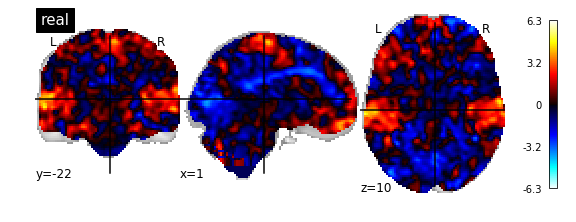

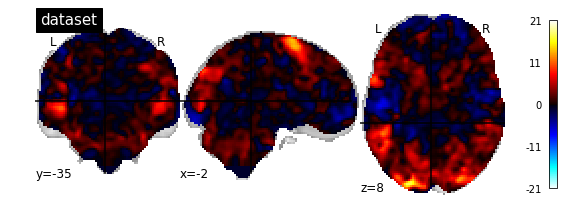

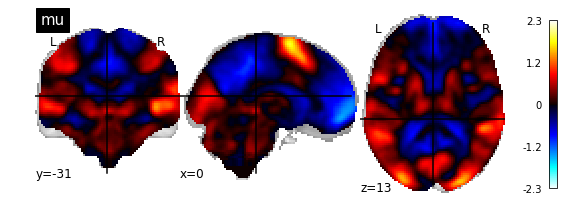

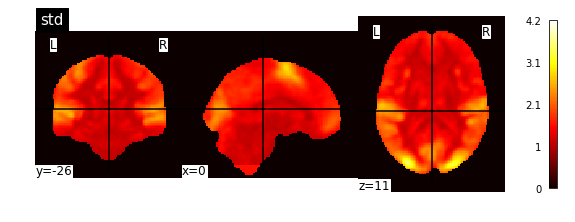

In [103]:
img = nibabel.load(rdf.loc[rdf.study=='archi'].iloc[0].z_map)
plotting.plot_stat_map(img, title="real")
x, s, t, c = trn["archi"][0]
plotting.plot_stat_map(nibabel.Nifti1Image(trn["archi"].mu + trn["archi"].std * x, constants.original_brain_mask.affine), title="dataset")
x = trn["archi"].mu
plotting.plot_stat_map(nibabel.Nifti1Image(x, constants.original_brain_mask.affine), title="mu")
x = trn["archi"].std
plotting.plot_stat_map(nibabel.Nifti1Image(x, constants.original_brain_mask.affine), title="std")

In [97]:
__study = "archi"
print(len(trn[__study]))
for i in [0,50,  201, 401, 1000]:
    x, s, t, c = trn[__study][i]
    ximg = nibabel.Nifti1Image(x, constants.brain_mask.affine)
    plotting.plot_stat_map(ximg, threshold=False)
    xvec = masking.apply_mask(ximg, constants.brain_mask)
    plt.figure()
    plt.hist(xvec)
    plt.title(str(c) + " " + str(xvec.mean()))

1170


AttributeError: module 'data.constants' has no attribute 'brain_mask'

10793


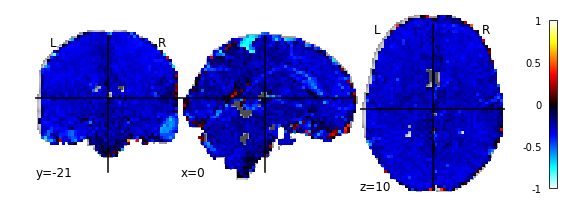

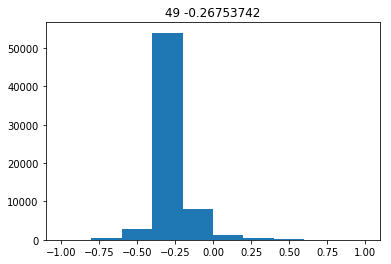

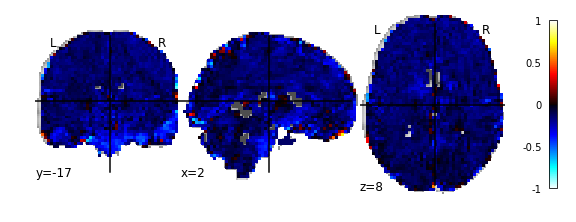

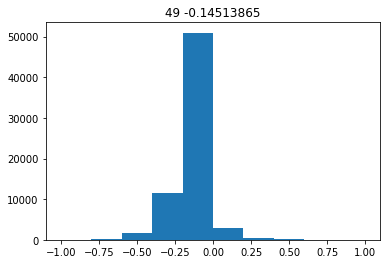

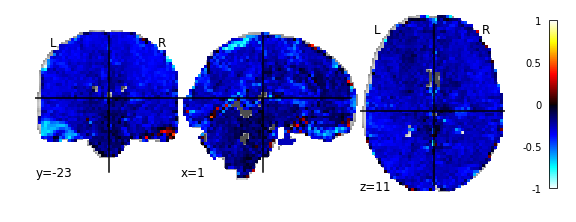

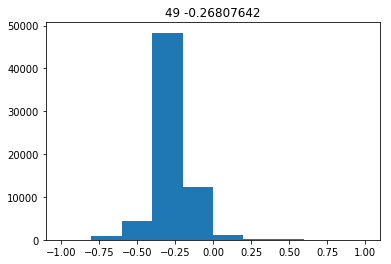

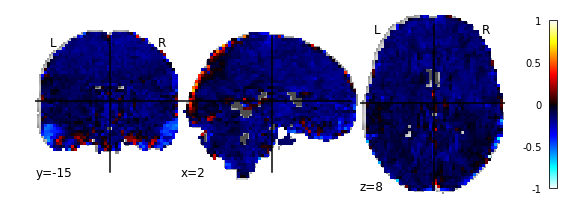

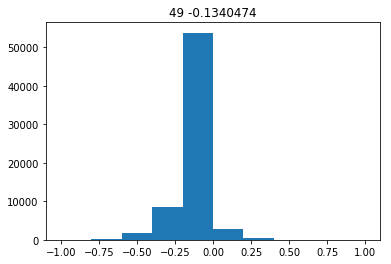

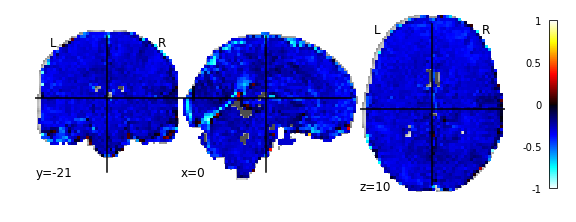

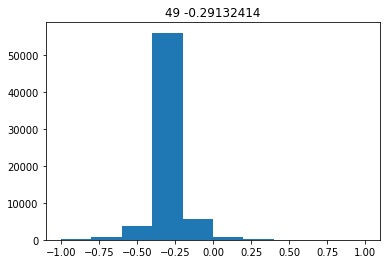

In [7]:
__study = "rfmri"
print(len(trn[__study]))
for i in [0,50,  201, 401, 1000]:
    x, s, t, c = trn[__study][i]
    ximg = nibabel.Nifti1Image(x, constants.brain_mask.affine)
    plotting.plot_stat_map(ximg, threshold=False)
    xvec = masking.apply_mask(ximg, constants.brain_mask)
    plt.figure()
    plt.hist(xvec)
    plt.title(str(c) + " " + str(xvec.mean()))

# Analysis of the model

In [9]:
base_dir_ = "conv/outputs/"
run_id_ = "rest_and_task"
model_type_ = "shacgan"
chk = get_checkpoint(4999, run_id=run_id_, model_type=model_type_, base_dir=base_dir_)
with open(os.path.join(base_dir_, model_type_, run_id_, "information.json")) as f:
    args = json.load(f)['args']
args = Namespace(**{k: v for k, v in args.items()})
args.meta['si2ti'] = {int(k): v for k, v in args.meta['si2ti'].items()}
args.meta['ti2ci'] = {int(k): v for k, v in args.meta['ti2ci'].items()}


In [10]:
model = shacgan.SHACGAN(
    args,
    gen_mask=constants.brain_mask_tensor if args.gen_mask else None,
    gen_version=args.generator_type,
    disc_version=args.discriminator_type,
    gradient_penalty=args.gp_type,
    loadable_state_dict=chk['model']
)

In [13]:
args.device

'cuda'

In [2]:
model

NameError: name 'model' is not defined